# $\S$ 11.5. Some Issues in Training Neural Networks

> There is quite an art in training neural networks.

The model is generally overparametrized, and the optimization problem is nonconvex and unstable unless certain guidelines are followed.

## $\S$ 11.5.1. Starting Values

Note that if the weights are near zero, then the operative part of the sigmoid (FIGURE 11.3) is roughly linear, and hence the neural network collapses into an approximately linear model (Exercise 11.2).

Usually starting values for weights are chosen to be random values near zero. Hence the model starts out nearly linear, and becomes nonlinear as the weights increases. Individual units localize to directions and introduce nonlinearities where needed.

Use of exact zero weight leads to zero derivatives and perfect symmetry, and the algorithm never moves.

Starting instead with large weights often leads to poor solutions.

## $\S$ 11.5.2. Overfitting

Often neural networks have too many weights and will overfit the data at the global minimum of $R$.

In early developments of neural networks, either by design or by accident, an early stopping rule was used to avoid overfitting. Here we train the model only for a while, and stop well before we approach the global minimum. Since the weights starts at a highly regularized (linear) solution, this has the effect of shrinking the final model toward a linear model. A validation dataset is useful for determining when to stop, since we expect the validation error to start increasing.

### Weight decay

A more explicit method for regularization is _weight decay_, which is analogous to ridge regression used for linear models ($\S$ 3.4.1). We add a penalty to the error function

\begin{equation}
R(\theta) + \lambda J(\theta),
\end{equation}

where

\begin{equation}
J(\theta) = \sum_{k,m} \beta_{km}^2 + \sum_{m,l} \alpha_{ml}^2
\end{equation}

and $\lambda \ge 0$ is a tuning parameter.

Larger values of $\lambda$ will tend to shrink the weights toward zero: Typically cross-validation is used to estimate $\lambda$. The effect of the penalty is to simply add terms $2\beta_{km}$ and $2\alpha_{ml}$ to the respective gradient expressions (11.13).

Other forms for the penalty have been proposed, e.g.,

\begin{equation}
J(\theta) = \sum_{k,m}\frac{\beta_{km}^2}{1+\beta_{km}^2} + \sum_{m,l}\frac{\alpha_{ml}^2}{1+\alpha_{ml}^2},
\end{equation}

known as the _weight elimination_ penalty. This has the effect of shrinking smaller weights more.

### Examples

FIGURE 11.4 shows the results of training a neural network with 10 hidden units, to the mixture example of Chapter 2. Weight decay has clearly improved the prediction.

FIGURE 11.5 shows heat maps of the estimated weights from the training (grayscale versions of these are called _Hinton diagrams_). We see that weight decay has dampened the weights in both layers: The resulting weights are spread fairly evenly over the 10 hidden units.

In [1]:
"""FIGURE 11.4. A neural network on the mixture example with and without weight decay."""
%matplotlib inline
import random
import scipy
import matplotlib.collections as colls
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch

In [2]:
def generate_data(sample_size:int)->tuple:
    """Taken from Section 2.3."""
    # Parameters for mean distributions
    mean_blue = [1, 0]
    mean_orange = [0, 1]
    mean_cov = scipy.eye(2)*1.2
    mean_size = 10
    
    # Additional parameters for blue and orange distributions
    sample_cov = scipy.eye(2)/5
    
    # Generate mean components for blue and orange (10 means for each)
    sample_blue_mean = scipy.random.multivariate_normal(mean_blue, mean_cov, mean_size)
    sample_orange_mean = scipy.random.multivariate_normal(mean_orange, mean_cov, mean_size)
    
    # Generate blue points
    sample_blue = scipy.array([
        scipy.random.multivariate_normal(sample_blue_mean[random.randint(0, 9)],
                                         sample_cov)
        for _ in range(sample_size)
    ])
    y_blue = scipy.zeros(sample_size)

    # Generate orange points
    sample_orange = scipy.array([
        scipy.random.multivariate_normal(sample_orange_mean[random.randint(0, 9)],
                                         sample_cov)
        for _ in range(sample_size)
    ])
    y_orange = scipy.ones(sample_size)

    data_x = scipy.concatenate((sample_blue, sample_orange), axis=0)
    data_y = scipy.concatenate((y_blue, y_orange))
    return data_x, data_y

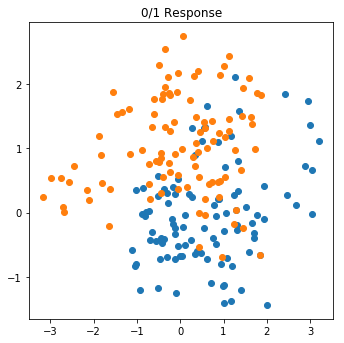

In [3]:
sample_size = 100
data_x, data_y = generate_data(sample_size)

# Plot
fig1 = plt.figure(1, figsize=(12, 12))
ax11 = fig1.add_subplot(2, 2, 1)

ax11.plot(data_x[data_y == 0, 0], data_x[data_y == 0, 1], 'o', color='C0')
ax11.plot(data_x[data_y == 1, 0], data_x[data_y == 1, 1], 'o', color='C1')
ax11.set_title('0/1 Response')
plt.show()

plot_x_min, plot_x_max = ax11.get_xlim()
plot_y_min, plot_y_max = ax11.get_ylim()

In [4]:
"""
References:
https://github.com/vinhkhuc/PyTorch-Mini-Tutorials/blob/master/3_neural_net.py
http://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module
http://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_optim.html
http://pytorch.org/docs/master/optim.html#torch.optim.SGD
"""
n, p, m, k = 200, 2, 10, 1
learning_rate = 1e-4

training_x = torch.autograd.Variable(torch.from_numpy(data_x).float())
training_y = torch.autograd.Variable(torch.from_numpy(data_y.reshape(200, 1)).float(),
                                     requires_grad=False)
# 1. No weight decay
model = torch.nn.Sequential(
    torch.nn.Linear(p, m, bias=True),
    torch.nn.Softmax(dim=1),
    torch.nn.Linear(m, k, bias=True),
    torch.nn.Sigmoid(),
)
loss_fn = torch.nn.BCELoss(size_average=False)

# 2. Weight decay with lambda 0.02
model_weightdecay = torch.nn.Sequential(
    torch.nn.Linear(p, m, bias=True),
    torch.nn.Softmax(dim=1),
    torch.nn.Linear(m, k, bias=True),
    torch.nn.Sigmoid(),
)
loss_fn_weightdecay = torch.nn.BCELoss(size_average=False)
optimizer = torch.optim.SGD(model_weightdecay.parameters(),
                            lr=learning_rate,
                            weight_decay=.02)

In [5]:
%%time
niter = 100000
for epoch in range(niter):
    # 1. No weight decay
    # Forward pass
    y_pred = model(training_x)
    
    # Compute loss
    loss = loss_fn(y_pred, training_y)
    
    # Zero the gradients before running backward pass
    model.zero_grad()
    
    # Backward pass
    loss.backward()
    
    # Update the weights using gradient descent
    for param in model.parameters():
        param.data -= learning_rate*param.grad.data

    # 2. Weight decay with lambda 0.02
    y_pred_wd = model_weightdecay(training_x)
    
    loss_wd = loss_fn_weightdecay(y_pred_wd, training_y)

    optimizer.zero_grad()
    
    loss_wd.backward()
    
    optimizer.step()

print(f'{niter} iterations done.')
print('loss without weight decay', loss.data[0])
print('loss with weight decay = 0.02', loss_wd.data[0])

100000 iterations done.
loss without weight decay 70.56473541259766
loss with weight decay = 0.02 70.7387924194336
CPU times: user 3min 22s, sys: 4.17 s, total: 3min 27s
Wall time: 1min 11s


In [6]:
# Test for the grid
test_grid_x = scipy.array([[x1, x2]
                           for x1 in scipy.linspace(plot_x_min, plot_x_max, 100)
                           for x2 in scipy.linspace(plot_y_min, plot_y_max, 100)])
test_x = torch.autograd.Variable(torch.from_numpy(test_grid_x).float(), requires_grad=False)
test_y = model(test_x)
test_y_wd = model_weightdecay(test_x)
test_g = scipy.where(test_y.data.numpy() >= .5, 1, 0).flatten()
test_g_wd = scipy.where(test_y_wd.data.numpy() >= .5, 1, 0).flatten()

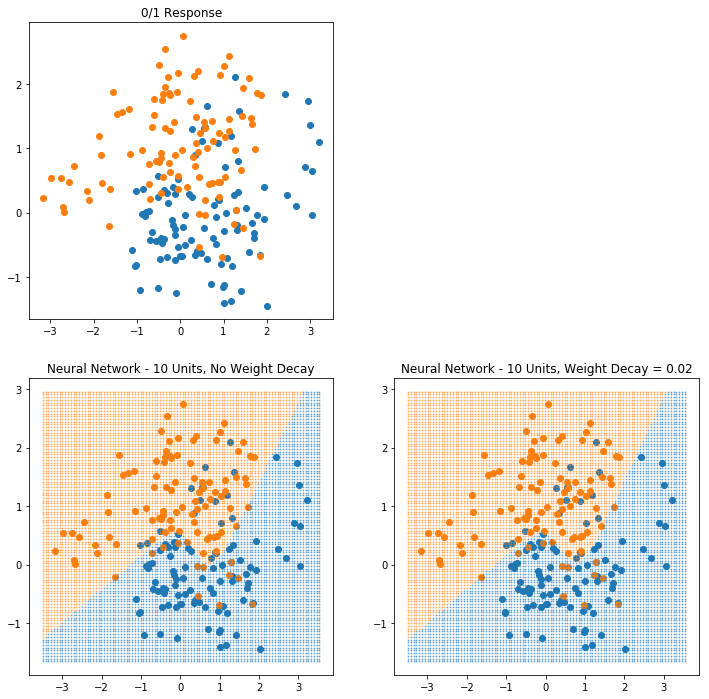

In [7]:
# Plot
ax12 = fig1.add_subplot(2, 2, 3)

ax12.plot(data_x[data_y == 0, 0], data_x[data_y == 0, 1], 'o', color='C0')
ax12.plot(data_x[data_y == 1, 0], data_x[data_y == 1, 1], 'o', color='C1')

ax12.plot(test_grid_x[test_g == 0, 0], test_grid_x[test_g == 0, 1], 'o',
          markersize=1, color='C0', alpha=.5)
ax12.plot(test_grid_x[test_g == 1, 0], test_grid_x[test_g == 1, 1], 'o',
          markersize=1, color='C1', alpha=.5)

ax12.set_title('Neural Network - 10 Units, No Weight Decay')

ax13 = fig1.add_subplot(2, 2, 4)
ax13.plot(data_x[data_y == 0, 0], data_x[data_y == 0, 1], 'o', color='C0')
ax13.plot(data_x[data_y == 1, 0], data_x[data_y == 1, 1], 'o', color='C1')

ax13.plot(test_grid_x[test_g_wd == 0, 0], test_grid_x[test_g_wd == 0, 1], 'o',
          markersize=1, color='C0', alpha=.5)
ax13.plot(test_grid_x[test_g_wd == 1, 0], test_grid_x[test_g_wd == 1, 1], 'o',
          markersize=1, color='C1', alpha=.5)

ax13.set_title('Neural Network - 10 Units, Weight Decay = 0.02')
fig1

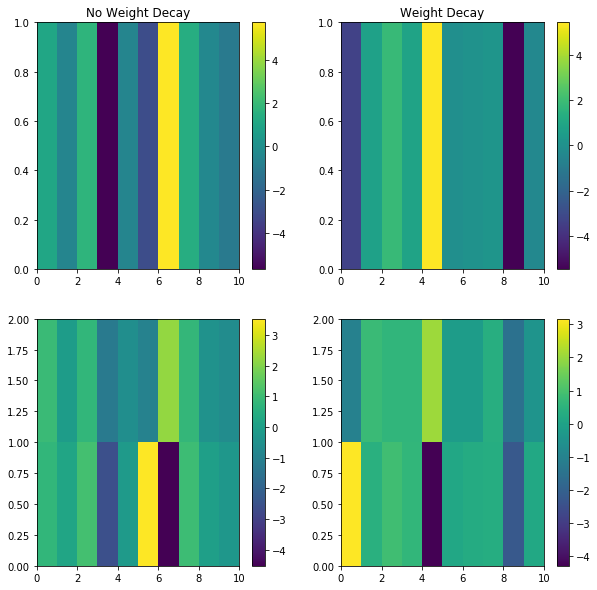

In [8]:
"""FIGURE 11.5. Heat maps of the estimated weights
References:
https://matplotlib.org/gallery/statistics/errorbars_and_boxes.html
https://matplotlib.org/examples/api/patch_collection.html
"""
training_parameters = list(model.parameters())
alpha = training_parameters[0].data.numpy().copy()
beta = training_parameters[2].data.numpy().copy().flatten()

fig2 = plt.figure(2, figsize=(10, 10))
ax21 = fig2.add_subplot(2, 2, 1)
patches_beta = [
    patches.Rectangle((b, 0), 1, 1)
    for b, _ in enumerate(beta)
]
colls_beta = colls.PatchCollection(patches_beta)
colls_beta.set_array(beta)
ax21.add_collection(colls_beta)
ax21.set_xlim(0, m)
ax21.set_ylim(0, 1)
ax21.set_title('No Weight Decay')
fig2.colorbar(colls_beta, ax=ax21)

ax23 = fig2.add_subplot(2, 2, 3)
patches_alpha = [
    patches.Rectangle((a1, a2), 1, 1)
    for a1, row in enumerate(alpha) for a2, _ in enumerate(row)
]
colls_alpha = colls.PatchCollection(patches_alpha)
colls_alpha.set_array(alpha.flatten())
ax23.add_collection(colls_alpha)
ax23.set_xlim(0, m)
ax23.set_ylim(0, p)
fig2.colorbar(colls_alpha, ax=ax23)

training_parameters_wd = list(model_weightdecay.parameters())
alpha_wd = training_parameters_wd[0].data.numpy().copy()
beta_wd = training_parameters_wd[2].data.numpy().copy().flatten()

ax22 = fig2.add_subplot(2, 2, 2)
patches_beta_wd = [
    patches.Rectangle((b, 0), 1, 1)
    for b, _ in enumerate(beta_wd)
]
colls_beta_wd = colls.PatchCollection(patches_beta_wd)
colls_beta_wd.set_array(beta_wd)
ax22.add_collection(colls_beta_wd)
ax22.set_xlim(0, m)
ax22.set_ylim(0, 1)
ax22.set_title('Weight Decay')
fig2.colorbar(colls_beta_wd, ax=ax22)

ax24 = fig2.add_subplot(2, 2, 4)
patches_alpha_wd = [
    patches.Rectangle((a1, a2), 1, 1)
    for a1, row in enumerate(alpha_wd) for a2, _ in enumerate(row)
]
colls_alpha_wd = colls.PatchCollection(patches_alpha_wd)
colls_alpha_wd.set_array(alpha_wd.flatten())
ax24.add_collection(colls_alpha_wd)
ax24.set_xlim(0, m)
ax24.set_ylim(0, p)
fig2.colorbar(colls_alpha_wd, ax=ax24)

plt.show()

## $\S$ 11.5.3. Scaling of the Inputs

Since the scaling of the inputs determines the effective scaling of the weights in the bottom layer, it can have a large effect on the quality of the final solution.

At the outset it is best to standardize all inputs to have mean zero and standard deviation one. This ensures all inputs are treated equally in the regularization process, and allows one to choose a meaningful range for the random starting weights.

With standardized inputs, it is typical to take random uniform weights over the range $[-0.7, +0.7]$.

## $\S$ 11.5.4. Number of Hidden Units and Layers

> Generally speaking it is better to have too many hidden units than too few.

* With too few hidden units, the model might not have enough flexibility to capture the nonlinearities in the data.
* With too many hidden units, the extra weights can be shrunk toward zero if appropriate regularization is used.

Typically the number of hidden units is somewhere in the range of 5 to 100, with the number increasing with the number of inputs and number of training cases. It is most common to put down a reasonably large number of units and train them with regularization.

Some researchers use cross-validation to estimate the optimal number, but this seems unnecessary if cross-validation is used to estimate the regularization parameter.

> Choice of the number of hidden layers is guided by background knowledge and experimentation.

Each layer extracts features of the input for regression or classification. Use of multiple hidden layers allows construction of hierarchical features at different levels of resolution (for an example see $\S$ 11.6).

## $\S$ 11.5.5. Multiple Minima

The error function $R(\theta)$ is nonconvex, possessing many local minima. As a result, the final solution obtained is quite dependent on the choice of starting weights. One must at least try a number of random starting configurations, and choose the solution giving lowest (penalizes) error.

Probabily a better approach is to use the average predictions over the collection of networks as the final prediction (Ripley, 1996). This is preferrable to averaging the weights, since the nonlinearity of the model implies that this averaged solution could be quite poor.

Another approach is via _bagging_, which averages the predictions of networks training from randomly perturbed versions of the training data ($\S$ 8.7).